In [1]:
#imports
try:
    from google.colab import drive
    #mount drive, set base path
    drive.mount("/gdrive")
    base_path = '/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites'
except:
    base_path = './'
from pathlib import Path
import matplotlib.pyplot as plt
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image

import copy


In [2]:
torch.cuda.is_available()

True

In [3]:
#dataset paths
#set these paths and file names depending on where you are and which labels you are using
#Maximum categories to bin the data
MAXCATEGORIES = 10
MAXROSCATEGORIES = 6
train_images_prefix = 'training_images'
val_images_prefix = 'validation_images'
test_images_prefix = 'test_images'



train_obj_prefix = 'training_objareas'
val_obj_prefix = 'validation_objareas'
test_obj_prefix = 'test_objareas'
train_img_prefix = 'training_imgareas'
val_img_prefix = 'validation_imgareas'
test_img_prefix = 'test_imgareas'

suffix = '_rand4_unique.npy'
catstr = f'_cat{MAXCATEGORIES}'
rosstr = f'_ros{MAXROSCATEGORIES}'


data_path = Path(base_path).joinpath('processed/')

train_images_path = Path(data_path).joinpath(train_images_prefix + suffix)
train_labels_path = Path(data_path).joinpath(train_obj_prefix + catstr + suffix)

val_images_path = Path(data_path).joinpath(val_images_prefix + suffix)
val_labels_path = Path(data_path).joinpath(val_obj_prefix + catstr + suffix)

In [4]:
#load the numpy dataset files
train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path).astype(int)
val_images = np.load(val_images_path)
val_labels = np.load(val_labels_path).astype(int)


In [5]:
np.sum(train_labels==0)

9949

In [6]:
# change labels so that they start at 0
# TODO this is only valid for counts - so we need a flag for this or change the generator or dataloader appropriately
#train_labels = (train_labels-1)
#val_labels = (val_labels-1)
print(train_labels, val_labels)

[3 0 6 ... 1 0 2] [3 5 3 ... 3 2 1]


Text(0.5, 1.0, 'count: 6')

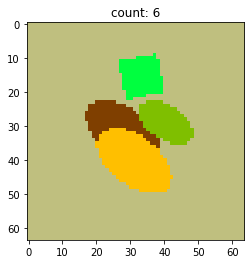

In [7]:
#examine data
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('count: ' + str(train_labels[idx]+1))

In [9]:
#utility functions for:
# setting the seed
# ensuring randomness of worker in data loader (overkill?)
# setting the device based on GPU availability

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda:2" if torch.cuda.is_available() else "cpu"
  if device != "cuda:2":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [10]:
#define the dataset class for our data for use by the dataloader
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x, y

    def __len__(self):
        return len(self.img_labels)

In [11]:
#instantiate the dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=train_transform)

In [12]:
#instantiate the dataloaders

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           num_workers=12,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=BATCH_SIZE,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [13]:
#define the train and test loops, and a wrapper that will call them to train and collect validation stats
def calc_error(output,target):
    return np.abs(output-target)/target

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current inpur model using the data
  from Train_loader and Updates parameters for a single pass
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    if reg_function1 is None:
      loss = criterion(output, target)
    elif reg_function2 is None:
      loss = criterion(output, target)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  """
  Tests the current Model
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return test_loss, 100. * correct / len(test_loader.dataset)



def main(args, model, train_loader, val_loader,
         criterion=F.nll_loss, reg_function1=None, reg_function2=None):
  """
  Trains the model with train_loader and tests the learned model using val_loader
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  val_acc_list, train_acc_list, val_loss_list, train_lost_list = [], [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_loss, train_acc = test(trained_model, train_loader, device=device)
    val_loss, val_acc = test(trained_model, val_loader, device=device)
    print(train_acc, val_acc)
    # param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    # param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, trained_model

def early_stopping_main(args, model, train_loader, val_loader, criterion=F.nll_loss, reg_function1=None, reg_function2=None):
  device = args['device']
  model = model.to(device)
  #optimizer = optim.RMSprop(model.parameters(),
  #                      lr=args['lr'],
  #                      momentum=args['momentum'])
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])
  best_acc = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 300

  # Keps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  val_acc_list, train_acc_list, val_loss_list, train_loss_list = [], [], [], []

  for epoch in tqdm(range(args['epochs'])):

    # train the model
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)

    # calculate training accuracy
    train_loss, train_acc = test(trained_model, train_loader, device=device)

    # calculate validation accuracy
    val_loss, val_acc = test(trained_model, val_loader, device=device)

    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      best_model = copy.deepcopy(trained_model)
      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f'early stopped on epoch: {epoch}')
      break
    
    if(epoch % 10 == 0):
        print(f'Epoch {epoch}, train acc {train_acc}, val acc {val_acc}, {train_loss}, {val_loss}')
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    #save the model
    if('checkpoint_path' in args):
        torch.save({
          'model_state_dict': best_model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, args['checkpoint_path'])
    
  return val_acc_list, train_acc_list, val_loss_list, train_loss_list, best_model, best_epoch

In [14]:
# Regularization functions
def l1_reg(model):
  """
    Inputs: Pytorch model
    This function calculates the l1 norm of the all the tensors in the model
  """
  l1 = 0.0
  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))

  return l1

def l2_reg(model):
  """
    Inputs: Pytorch model
    This function calculates the l1 norm of the all the tensors in the model
  """
  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(param**2)

  return l2

In [15]:
#define the MLP model
class AnimalNet(nn.Module):
  def __init__(self):
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 64 * 64, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

CNN model

In [16]:
# Create a sample network
class conv_net(nn.Module):
  def __init__(self):
    super().__init__()
    # First define the layers.
    self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
    self.dropout = nn.Dropout(0.5)
    self.fc1 = nn.Linear(7*7*64, 256)
    self.fc2 = nn.Linear(256, 4)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
#     x = self.dropout(x)

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout(x)
    
    # Conv layer 3.
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout(x)

    # Fully connected layer 1.
    x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                            # previous convolution layer.
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)

    # Fully connected layer 2.
    x = self.fc2(x)
    x = F.log_softmax(x,dim=1)

    return x

In [17]:
# Create a sample network
class conv_net1(nn.Module):
  def __init__(self):
    super().__init__()
    # First define the layers.
    self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1)
    self.dropout = nn.Dropout(0.5)
    self.fc1 = nn.Linear(7*7*64, 256)
    self.fc2 = nn.Linear(256, 4)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
#     x = self.dropout(x)

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout(x)
    
    # Conv layer 3.
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout(x)

    # Fully connected layer 1.
    x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                            # previous convolution layer.
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)

    # Fully connected layer 2.
    x = self.fc2(x)
    x = F.log_softmax(x,dim=1)

    return x

In [18]:
# Create a sample network
class conv_net2(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)

        return x

In [19]:
# Create a sample network
class conv_net3(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(69696, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
#         x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
#         x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
#         x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)

        return x

In [20]:
#set the hyper parameters
# Set the arguments
args = {
    'epochs': 300,
    'lr': 0.005,
    'momentum': 0.8,
    'device': DEVICE,
    'pretrained_path':'./pretrained/cnn3_cat_objcount_lr0.01_mmt0.8.pt',
    'checkpoint_path':'./pretrained/cnn2_cat_obj2area_ft_cat10_lr0.005_mmt0.8.pt'
}



Random seed 2021 has been set.


Epoch 0, train acc 55.782, val acc 56.36, 1.011508794708252, 1.0040662626266479
Epoch 10, train acc 67.6, val acc 67.58, 0.7342486950683593, 0.7369061443328857
Epoch 20, train acc 69.182, val acc 69.34, 0.6864918414306641, 0.6940209956169129
Epoch 30, train acc 71.742, val acc 71.57, 0.6271011899566651, 0.6429311575889587
Epoch 40, train acc 77.83, val acc 76.72, 0.5284372873687744, 0.5552230998039246
Epoch 50, train acc 75.914, val acc 74.7, 0.5513249529266357, 0.5840179957389832
Epoch 60, train acc 80.65, val acc 78.07, 0.48281674880981446, 0.5242515293598176
Epoch 70, train acc 77.558, val acc 76.2, 0.5111818047332763, 0.5522752454280854
Epoch 80, train acc 78.182, val acc 76.43, 0.5017359201812744, 0.5481551593780517
Epoch 90, train acc 81.75, val acc 79.32, 0.4434653667831421, 0.49718794541358946
Epoch 100, train acc 82.392, val acc 78.65, 0.43848309967041016, 0.5033532830238342
Epoch 110, train acc 82.22, val acc 79.37, 0.43660437992095946, 0.49282887506484985
Epoch 120, train ac

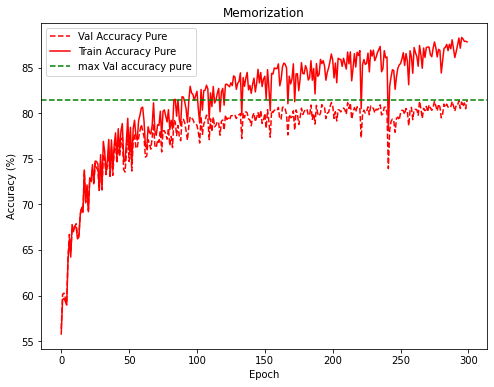

In [21]:
#run the training and plot results

# Initialize the network
set_seed(seed=SEED)
model = conv_net2()
if ('pretrained_path' in args):
    checkpoint = torch.load(args['pretrained_path'])
    model.load_state_dict(checkpoint['model_state_dict'])
#we are fine tuning, so don't set requires_grad to False, just replace the two fully connected layers
#for param in model.parameters():
#  param.requires_grad = False
num_ftrs = model.fc2.in_features
model.fc2 = nn.Linear(num_ftrs, MAXCATEGORIES)

start_time = time.time()
# Train the network
val_acc_pure,train_acc_pure,val_loss_list, train_loss_list, best_model,best_epoch = early_stopping_main(args=args,
                                                                          model=model,
                                                                          train_loader=train_loader,
                                                                          val_loader=val_loader)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
#validate we can load the pretrained weights and use them
model = conv_net2()

if ('pretrained_path' in args):
    checkpoint = torch.load(args['pretrained_path'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(args['device'])
    model.eval()
    val_acc = test(model, val_loader, device=args['device'])
    print(val_acc)
else:
    print('No checkpoint was saved')



89.47


In [28]:
print(args['device'])

cuda:1


In [29]:
from torchinfo import summary
print(model)
im = torch.Tensor(np.random.rand(1, 3, 64, 64))
im = im.to(args['device'])
print(im.shape)
model(im)
summary(model, input_size=(1, 3, 64, 64))

conv_net2(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)
torch.Size([1, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
conv_net2                                --                        --
├─Conv2d: 1-1                            [1, 32, 63, 63]           1,568
├─Conv2d: 1-2                            [1, 64, 31, 31]           18,496
├─Dropout: 1-3                           [1, 64, 15, 15]           --
├─Conv2d: 1-4                            [1, 64, 16, 16]           16,448
├─Dropout: 1-5                           [1, 64, 8, 8]             --
├─Conv2d: 1-6                            [1, 64, 9, 9]             16,448
├─Linear: 1-7                            [1, 256]                  262,400
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 4]                    1,028
Total params: 316,388
Trainable params: 316,388
Non-trainable params: 0
Total mult-adds (M): 29.80
Input size (MB): 0.05
Forward/backward pass size (MB): 1.68
Params size (MB): 1.27
Estimated Total Size